In [95]:
import numpy as np
from mpmath import mp, mpf, sin, pi, fadd, fsub, fmul, fdiv, fabs, fsum
import matplotlib.pyplot as plt

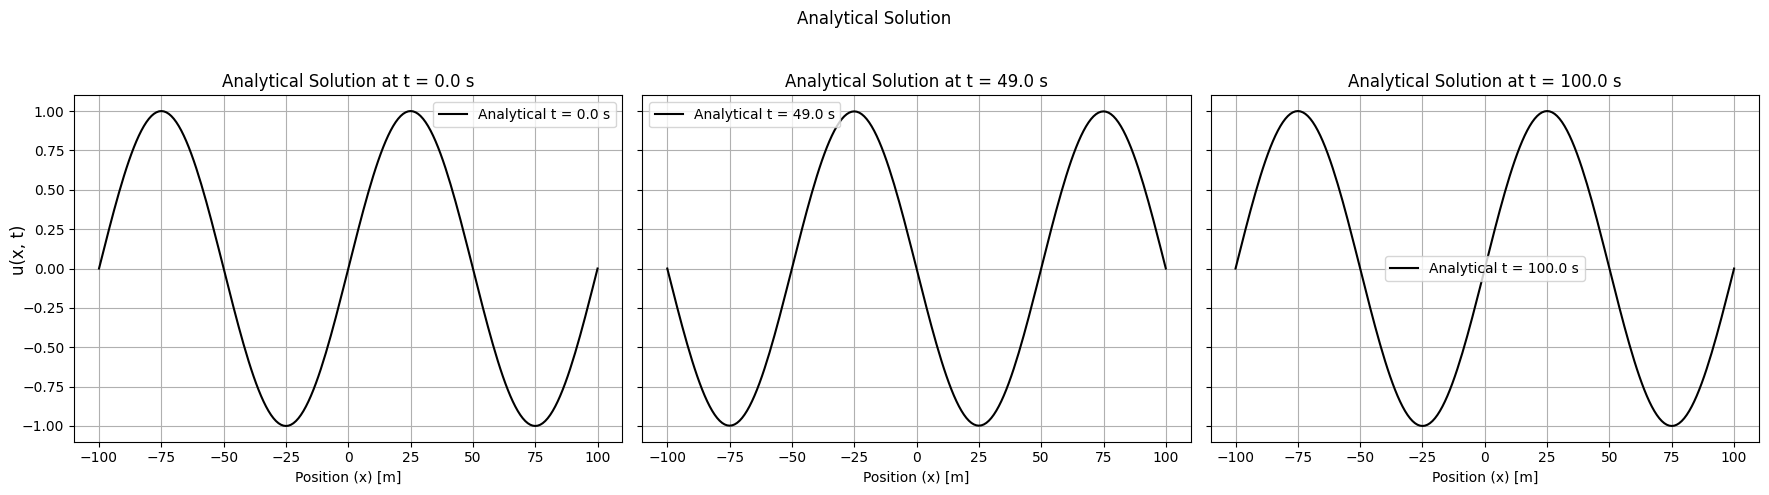

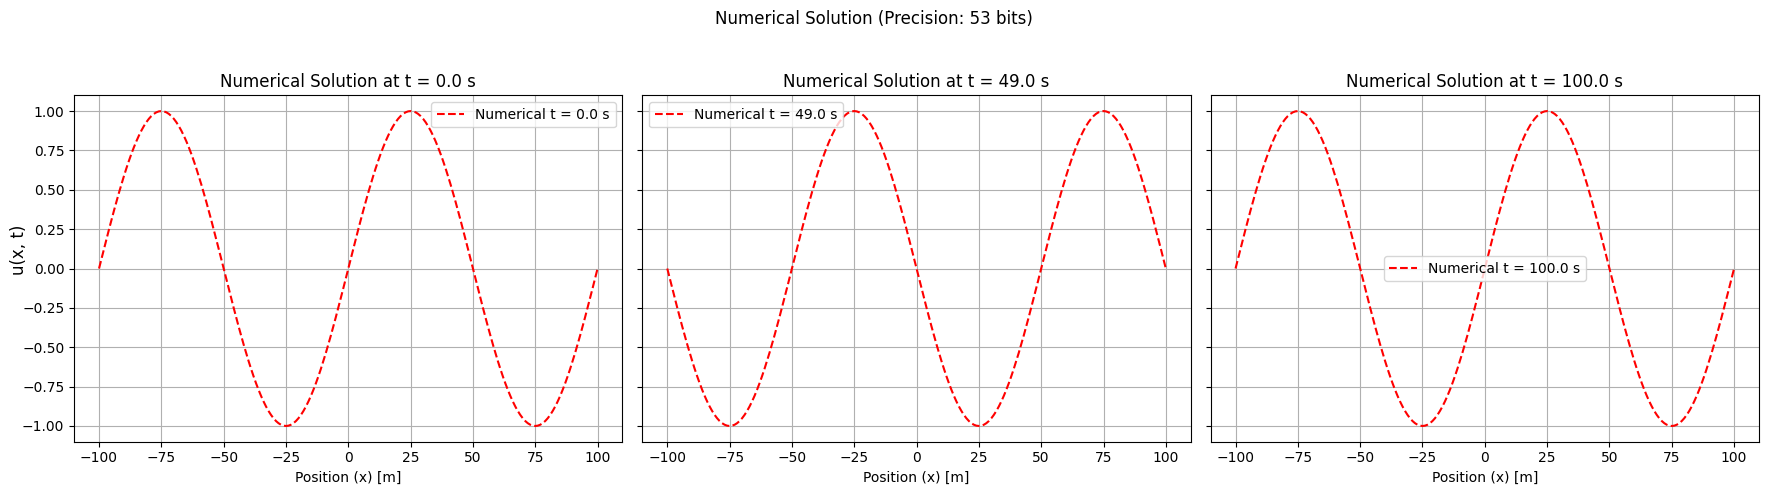

In [96]:
# Set precision
mp.prec = 53

# Constants
L = mpf(100)                 # Half-length of the domain in meters
c = mpf(1)                 # Wave speed in m/s
N = 201                       # Number of spatial points
dx = mpf(1)          # Spatial step size for [-L, L] domain
dt = mpf(1)        # Time step size (CFL condition)
T = mpf(100.0)                  # Total simulation time in seconds, after scaling period becomes 100
x = [mpf(val) for val in np.linspace(float(-L), float(L), N)]  # Spatial grid as mpf

# Total time steps
Nt = int(T / dt) + 1

# Initialize the wave field
u = [sin(2 * pi * x_i / L) for x_i in x]  # Initial condition u(x, 0)
u_prev = u.copy()                         # Initial velocity is zero: u_t(x, 0) = 0
u_next = [mpf(0)] * N                     # Placeholder for the next time step

# Dynamic time indices for plotting
plot_times = [0, Nt // 2 - 1, Nt - 1]  # Start, middle, and end of the time range
u_num_at_t = {}

# Separate variables for analytical solution using NumPy
L_np = float(L)  # Half-length of the domain in meters for NumPy
c_np = float(c)  # Wave speed in m/s for NumPy
x_np = np.linspace(-L_np, L_np, N)  # Spatial grid for NumPy

# Main time evolution loop
for n in range(Nt):
    # Store the results for specific time indices
    if n in plot_times:
        u_num_at_t[n] = u.copy()  # Store the wave profile at the specified time indices
    
    # Compute the next time step using finite difference
    for i in range(1, N - 1):
        # Compute coefficients explicitly
        coeff = fdiv(fmul(mpf(c), mpf(dt)), mpf(dx))
        coeff_squared = fmul(coeff, coeff)  # (c * dt / dx) ** 2
        
        # Update u_next[i] using explicit mpmath operations
        term1 = fmul(mpf(2), u[i])  # 2 * u[i]
        term2 = fsub(u[i + 1], fmul(mpf(2), u[i]))  # u[i + 1] - 2 * u[i]
        term2 = fadd(term2, u[i - 1])  # u[i + 1] - 2 * u[i] + u[i - 1]
        update = fmul(coeff_squared, term2)  # (c * dt / dx) ** 2 * (term2)
        u_next[i] = fadd(fsub(term1, u_prev[i]), update)  # 2 * u[i] - u_prev[i] + update
    
    # Apply boundary conditions
    u_next[0] = mpf(0)  # Fixed boundary
    u_next[-1] = mpf(0)

    # Update arrays for the next time step
    u_prev = u.copy()
    u = u_next.copy()


# Analytical Solution (uses separate NumPy variables)
def analytical_solution_numpy(x_np, t, c_np, L_np):
    t_np = float(t)  # Convert time to float
    return np.cos(2 * np.pi * c_np * t_np / L_np) * np.sin(2 * np.pi * x_np / L_np)

## Plotting the analytical solution
fig1, axs1 = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for i, idx in enumerate(plot_times):
    t = idx * dt
    # Analytical solution at time t using NumPy variables
    u_analytic = analytical_solution_numpy(x_np, t, c_np, L_np)
    axs1[i].plot(x_np, u_analytic, 'k-', label=f"Analytical t = {float(t)} s")

    # Plot formatting
    axs1[i].set_xlabel("Position (x) [m]")
    axs1[i].set_title(f"Analytical Solution at t = {float(t)} s")
    axs1[i].legend()
    axs1[i].grid(True)

# Set global y-axis label
fig1.supylabel("u(x, t)")
fig1.suptitle("Analytical Solution")
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Plotting the numerical solution
fig2, axs2 = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for i, idx in enumerate(plot_times):
    t = idx * dt
    # Retrieve the numerical solution for the mapped time index
    u_num = u_num_at_t[idx]
    axs2[i].plot([float(x_i) for x_i in x], [float(u_n) for u_n in u_num], 'r--', label=f"Numerical t = {float(t)} s")

    # Plot formatting
    axs2[i].set_xlabel("Position (x) [m]")
    axs2[i].set_title(f"Numerical Solution at t = {float(t)} s")
    axs2[i].legend()
    axs2[i].grid(True)

# Set global y-axis label
fig2.supylabel("u(x, t)")
fig2.suptitle(f"Numerical Solution (Precision: {mp.prec} bits)")
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()


In [98]:
# u is updated at each time step
# i want to see the fourier transform of the wavefield at the start and end 
# retrieve the wavefield at t0 and tN, fft, plot